(**Click the icon below to open this notebook in Colab**)

[![Open InColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/xiangshiyin/machine-learning-for-actuarial-science/blob/main/2025-spring/week09/notebook/demo.ipynb)

# Imbalanced Data

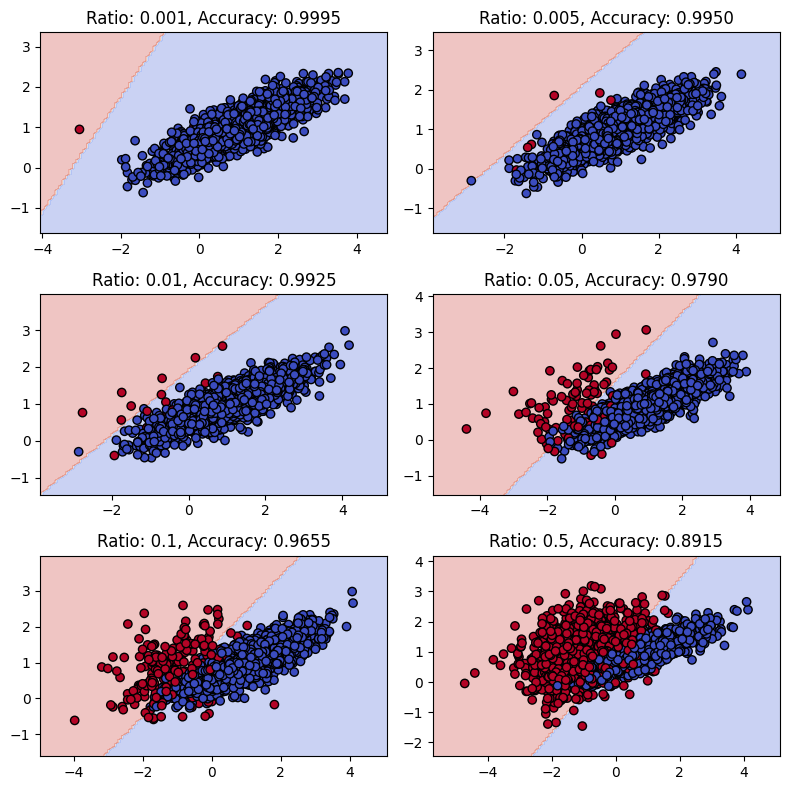

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

def generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.05, random_state=1):
    X, y = make_classification(n_samples=n_sample, n_features=2, n_redundant=0, n_clusters_per_class=1,
                               weights=[1 - minority_ratio], class_sep=1, flip_y=0, random_state=random_state)
    return X, y

# Function to plot decision boundaries
def plot_decision_boundaries(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

inputs_to_visualize = []
for minority_ratio in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
    # Generate an imbalanced dataset
    X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=minority_ratio)
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
    # Fit a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # Check the accuracy
    accuracy = accuracy_score(y_test, model.predict(X_test))
    # Store the input data for visualization
    inputs_to_visualize.append((minority_ratio, model, X_test, y_test, accuracy))

# visualize all in a 1x3 grid
nrow, ncol = 3, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(8, 8))
for i, (minority_ratio, model, X_input, y_input, accuracy) in enumerate(inputs_to_visualize):
    plot_decision_boundaries(model, X_input, y_input, axes[i//ncol][i%ncol], f"Ratio: {minority_ratio}, Accuracy: {accuracy:.4f}")
plt.tight_layout()
plt.show()


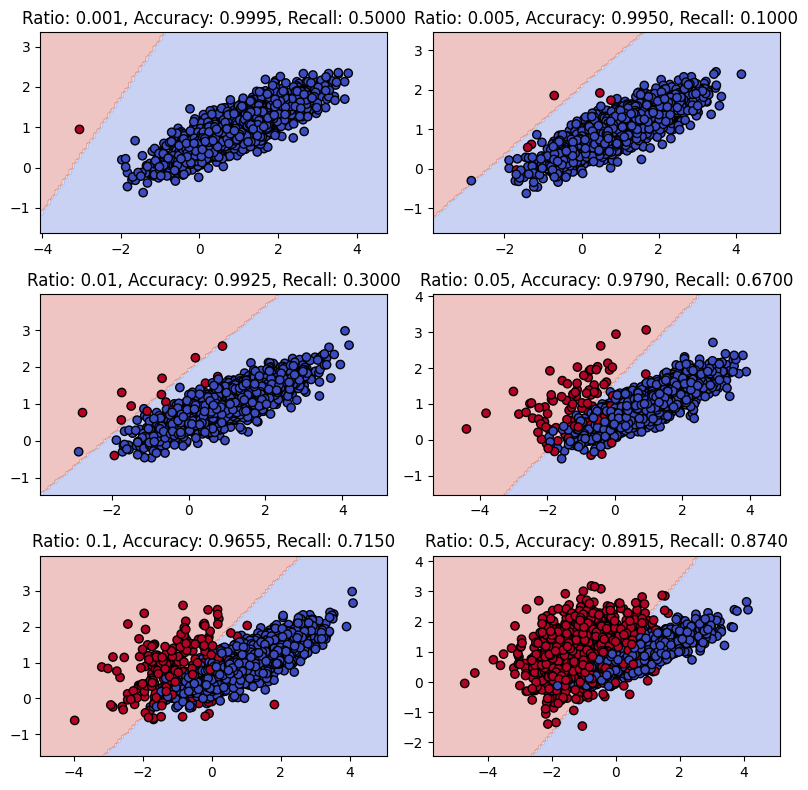

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score

def generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.05, random_state=1):
    X, y = make_classification(n_samples=n_sample, n_features=2, n_redundant=0, n_clusters_per_class=1,
                               weights=[1 - minority_ratio], class_sep=1, flip_y=0, random_state=random_state)
    return X, y

# Function to plot decision boundaries
def plot_decision_boundaries(model, X, y, ax, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

inputs_to_visualize = []
for minority_ratio in [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]:
    # Generate an imbalanced dataset
    X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=minority_ratio)
    # Split the dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12, stratify=y)
    # Fit a logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    # Check the accuracy and recall
    accuracy = accuracy_score(y_test, model.predict(X_test))
    recall = recall_score(y_test, model.predict(X_test))
    # Store the input data for visualization
    inputs_to_visualize.append((minority_ratio, model, X_test, y_test, accuracy, recall))

# visualize all in a 1x3 grid
nrow, ncol = 3, 2
fig, axes = plt.subplots(nrow, ncol, figsize=(8, 8))
for i, (minority_ratio, model, X_input, y_input, accuracy, recall) in enumerate(inputs_to_visualize):
    plot_decision_boundaries(model, X_input, y_input, axes[i//ncol][i%ncol], f"Ratio: {minority_ratio}, Accuracy: {accuracy:.4f}, Recall: {recall:.4f}")
plt.tight_layout()
plt.show()


# Model Evaluation with Imbalanced Data

- Cross validation score prameter [[doc](https://scikit-learn.org/stable/modules/model_evaluation.html#the-scoring-parameter-defining-model-evaluation-rules)]

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01)
lr = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(lr, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(lr, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(lr, X, y, scoring='recall', cv=cv, n_jobs=-1)
f1s = cross_val_score(lr, X, y, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.9449
Mean Accuracy: 0.9946
Mean Recall: 0.4967
Mean F1: 0.6288


## ROC-AUC

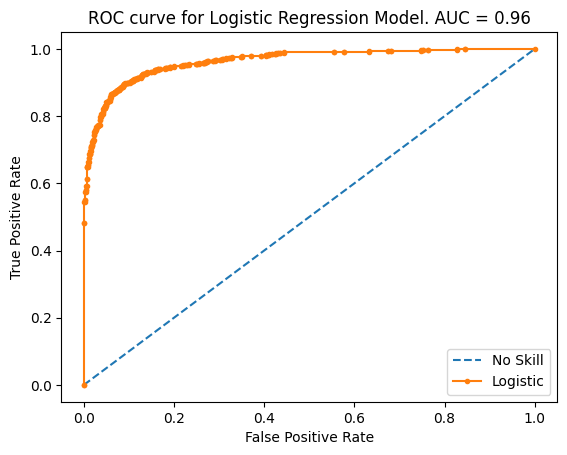

In [4]:
# example of a roc curve for a predictive model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# generate 2 class dataset
X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.5)
# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
# fit a model
lr = LogisticRegression()
lr.fit(X_train, y_train)
# predict probabilities
yhat = lr.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for the model
fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
roc_auc_lr = roc_auc_score(y_test, pos_probs)
# plot lr roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title(f'ROC curve for Logistic Regression Model. AUC = {roc_auc_lr:.2f}')
plt.show()

In [5]:
from sklearn.dummy import DummyClassifier

dc = DummyClassifier(strategy='stratified')
dc.fit(X_train, y_train)
yhat_dummy = dc.predict_proba(X_test)
pos_probs_dummy = yhat_dummy[:, 1]
# calculate roc auc
roc_auc_dummy = roc_auc_score(y_test, pos_probs_dummy)
print(f'ROC AUC = {roc_auc_dummy:.2f}')

ROC AUC = 0.50


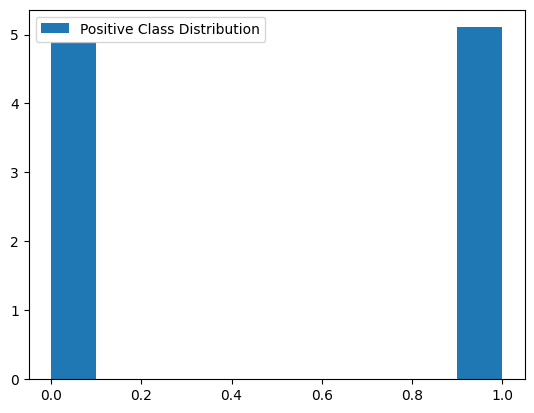

In [6]:
pos_probs_dummy = yhat_dummy[:, 1]

plt.hist(pos_probs_dummy, bins=10, label='Positive Class Distribution', density=True)
plt.legend()
plt.show()

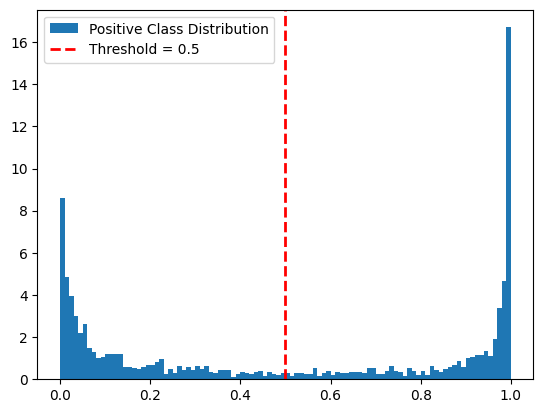

In [7]:
pos_probs = yhat[:, 1]
neg_probs = yhat[:, 0]

plt.hist(pos_probs, bins=100, label='Positive Class Distribution', density=True)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.legend()
plt.show()

In [8]:
recall = recall_score(y_test, lr.predict(X_test))
print(f"Recall: {recall}")

Recall: 0.891


In [9]:
np.sum(pos_probs>=0.5), np.sum(pos_probs<0.5)

(np.int64(978), np.int64(1022))

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


|               | Negative Prediction | Positive Prediction |
|--------------|--------------------|--------------------|
| **Negative Class** | True Negative (TN)  | False Positive (FP) |
| **Positive Class** | False Negative (FN) | True Positive (TP) |

In [10]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, lr.predict(X_test))
print(matrix)

[[913  87]
 [109 891]]


## PR-AUC

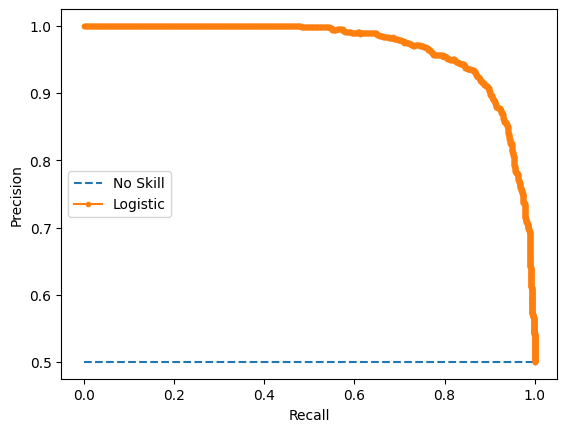

In [11]:
from sklearn.metrics import precision_recall_curve

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [12]:
from sklearn.metrics import auc

auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

PR AUC: 0.968


In [13]:


precision_dummy, recall_dummy, _ = precision_recall_curve(y_test, pos_probs_dummy)
auc_score = auc(recall_dummy, precision_dummy)
print('PR AUC: %.3f' % auc_score)

PR AUC: 0.627


## Severly Imbalanced Data

### ROC-AUC

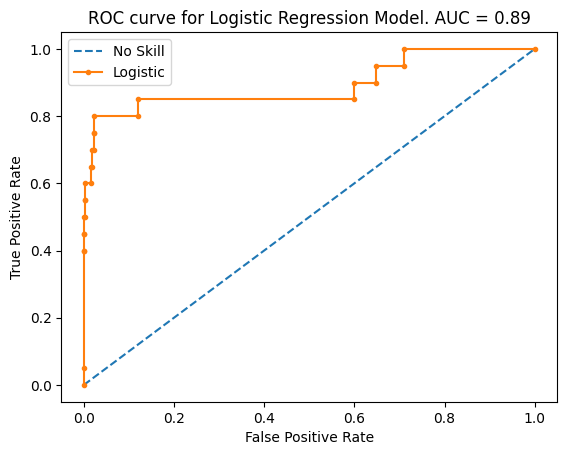

In [14]:
# example of a roc curve for a predictive model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# generate 2 class dataset
X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01)
# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2, stratify=y)
# fit a model
lr = LogisticRegression()
lr.fit(X_train, y_train)
# predict probabilities
yhat = lr.predict_proba(X_test)
# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for the model
fpr, tpr, thresholds = roc_curve(y_test, pos_probs)
roc_auc_lr = roc_auc_score(y_test, pos_probs)
# plot lr roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.title(f'ROC curve for Logistic Regression Model. AUC = {roc_auc_lr:.2f}')
plt.show()

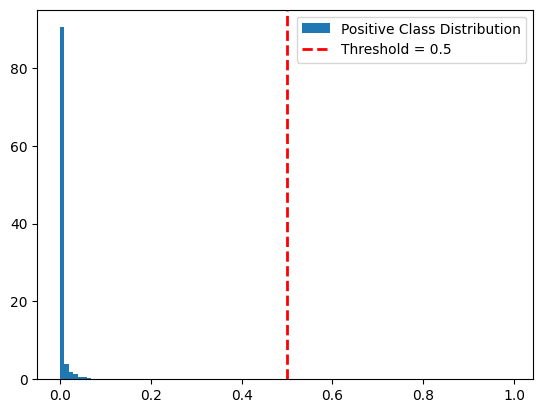

In [15]:
pos_probs = yhat[:, 1]

plt.hist(pos_probs, bins=100, label='Positive Class Distribution', density=True)
plt.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.legend()
plt.show()

In [16]:
recall = recall_score(y_test, lr.predict(X_test))
print(f"Recall: {recall}")

Recall: 0.35


In [17]:
np.sum(pos_probs>=0.5), np.sum(pos_probs<0.5)

(np.int64(7), np.int64(1993))

In [18]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_test, lr.predict(X_test))
print(matrix)

[[1980    0]
 [  13    7]]


In [19]:
7 / 20

0.35

### PR-AUC

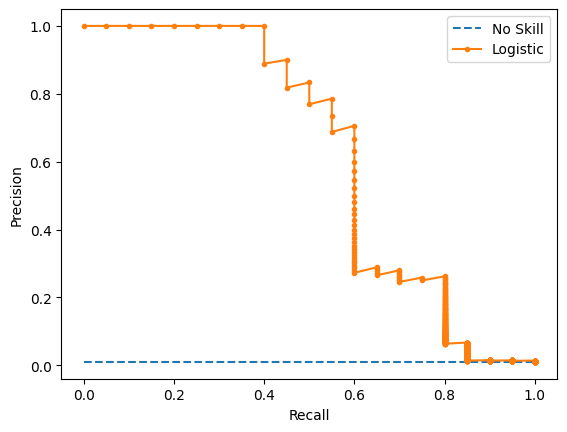

In [20]:
from sklearn.metrics import precision_recall_curve

# retrieve just the probabilities for the positive class
pos_probs = yhat[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, pos_probs)
# plot the model precision-recall curve
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

To explain why the ROC and PR curves tell a different story, recall that the PR curve focuses on the minority class, whereas the ROC curve covers both classes.

In [21]:
from sklearn.metrics import auc

auc_score = auc(recall, precision)
print('PR AUC: %.3f' % auc_score)

PR AUC: 0.618


# SMOTE (Synthetic Minority Over-sampling Technique)

In [22]:
import imblearn

imblearn.__version__

'0.13.0'

Counter({np.int64(0): 9900, np.int64(1): 100})


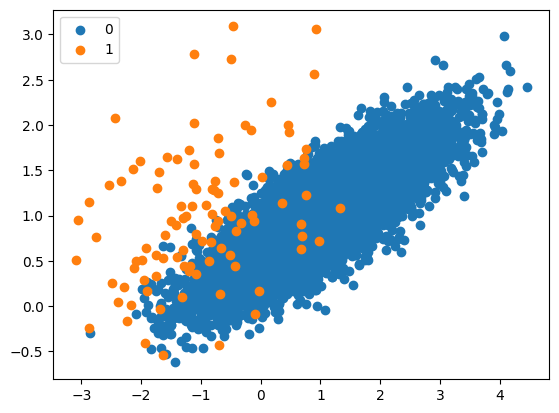

In [23]:
from collections import Counter

# define dataset
X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)

for label in counter:
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    
plt.legend()
plt.show()

Counter({np.int64(0): 9900, np.int64(1): 9900})


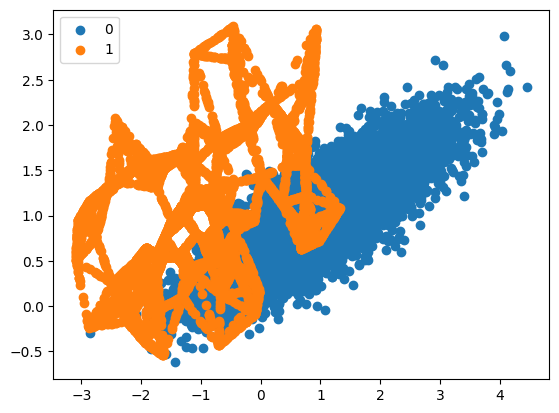

In [24]:
from imblearn.over_sampling import SMOTE

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01, random_state=1)
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
print(counter)

for label in counter:
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    
plt.legend()
plt.show()

The original paper on SMOTE suggested combining SMOTE with random undersampling of the majority class.

Counter({np.int64(0): 9900, np.int64(1): 100})
Counter({np.int64(0): 9900, np.int64(1): 990})


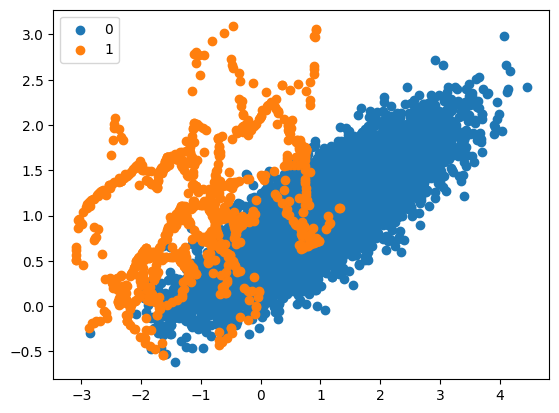

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01, random_state=1)
counter = Counter(y)
print(counter)

over = SMOTE(sampling_strategy=0.1)
X, y = over.fit_resample(X, y)
counter = Counter(y)
print(counter)

for label in counter:
    row_ix = np.where(y == label)[0]
    plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
    
plt.legend()
plt.show()

Counter({np.int64(0): 9900, np.int64(1): 100})
Counter({np.int64(0): 1980, np.int64(1): 990})


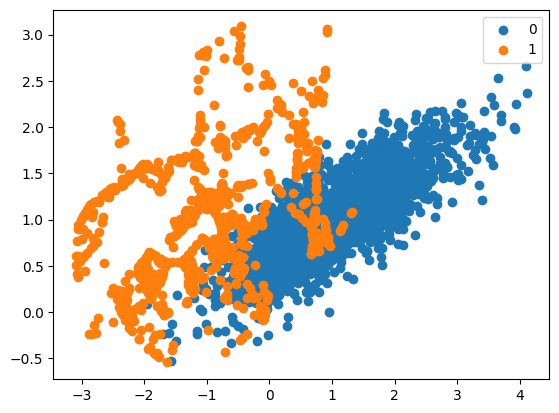

In [26]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01, random_state=1)
counter = Counter(y)
print(counter)

over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label in counter:
	row_ix = np.where(y == label)[0]
	plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.legend()
plt.show()

# Classification with SMOTE

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01)
lr = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(lr, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(lr, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(lr, X, y, scoring='recall', cv=cv, n_jobs=-1)
f1s = cross_val_score(lr, X, y, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.9449
Mean Accuracy: 0.9946
Mean Recall: 0.4967
Mean F1: 0.6288


In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01)
lr = LogisticRegression()
oversample = SMOTE()

steps = [
    ('over', oversample),
    ('model', lr)
]
pipeline = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
f1s = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.9458
Mean Accuracy: 0.9239
Mean Recall: 0.8700
Mean F1: 0.1884


In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01)
lr = LogisticRegression()
oversample = SMOTE(sampling_strategy=0.1)
undersample = RandomUnderSampler(sampling_strategy=0.5)

steps = [
    ('over', oversample),
    ('under', undersample),
    ('model', lr)
]
pipeline = Pipeline(steps=steps)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
precisions = cross_val_score(pipeline, X, y, scoring='precision', cv=cv, n_jobs=-1)
f1s = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean Precision: %.4f' % np.mean(precisions))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.9453
Mean Accuracy: 0.9620
Mean Recall: 0.8333
Mean Precision: 0.1869
Mean F1: 0.3040


In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

X, y = generate_imbalanced_dataset(n_sample=10000, minority_ratio=0.01)

k_values = [1, 2, 3, 4, 5, 6, 7]

for k in k_values:
    print('Testing k=%d' % k)
    lr = LogisticRegression()
    oversample = SMOTE(sampling_strategy=0.1, k_neighbors=k)
    undersample = RandomUnderSampler(sampling_strategy=0.5)

    steps = [
        ('over', oversample),
        ('under', undersample),
        ('model', lr)
    ]
    pipeline = Pipeline(steps=steps)

    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    roc_aucs = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    accuracies = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    recalls = cross_val_score(pipeline, X, y, scoring='recall', cv=cv, n_jobs=-1)
    precisions = cross_val_score(pipeline, X, y, scoring='precision', cv=cv, n_jobs=-1)
    f1s = cross_val_score(pipeline, X, y, scoring='f1', cv=cv, n_jobs=-1)

    print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
    print('Mean Accuracy: %.4f' % np.mean(accuracies))
    print('Mean Recall: %.4f' % np.mean(recalls))
    print('Mean Precision: %.4f' % np.mean(precisions))
    print('Mean F1: %.4f' % np.mean(f1s))

Testing k=1
Mean ROC AUC: 0.9472
Mean Accuracy: 0.9588
Mean Recall: 0.8267
Mean Precision: 0.1772
Mean F1: 0.2869
Testing k=2
Mean ROC AUC: 0.9467
Mean Accuracy: 0.9620
Mean Recall: 0.8233
Mean Precision: 0.1846
Mean F1: 0.3054
Testing k=3
Mean ROC AUC: 0.9461
Mean Accuracy: 0.9612
Mean Recall: 0.8333
Mean Precision: 0.1880
Mean F1: 0.2982
Testing k=4
Mean ROC AUC: 0.9459
Mean Accuracy: 0.9616
Mean Recall: 0.8267
Mean Precision: 0.1896
Mean F1: 0.3019
Testing k=5
Mean ROC AUC: 0.9451
Mean Accuracy: 0.9617
Mean Recall: 0.8367
Mean Precision: 0.1884
Mean F1: 0.3103
Testing k=6
Mean ROC AUC: 0.9452
Mean Accuracy: 0.9618
Mean Recall: 0.8333
Mean Precision: 0.1932
Mean F1: 0.3051
Testing k=7
Mean ROC AUC: 0.9460
Mean Accuracy: 0.9627
Mean Recall: 0.8333
Mean Precision: 0.1898
Mean F1: 0.3053


# Example: German Credit Risk data
- https://www.kaggle.com/datasets/uciml/german-credit

In this dataset
- Each entry represents a person who takes a credit by a bank. 
- Each person is classified as good or bad credit risks according to the set of attributes.

The selected attributes are:
- **Age** (numeric)
- **Sex** (text: male, female)
- **Job** (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- **Housing** (text: own, rent, or free)
- **Saving accounts** (text - little, moderate, quite rich, rich)
- **Checking account** (numeric, in DM - Deutsch Mark)
- **Credit amount** (numeric, in DM)
- **Duration** (numeric, in month)
- **Purpose** (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

In [31]:
import pandas as pd

credit = pd.read_csv('../data/credit_data_risk.csv')
credit.head(3)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good


In [32]:
credit.drop(columns=['Unnamed: 0'], inplace=True)

## Data Exploration

In [33]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [34]:
credit['Saving accounts'].value_counts()

Saving accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64

In [35]:
credit['Checking account'].value_counts()

Checking account
little      274
moderate    269
rich         63
Name: count, dtype: int64

In [36]:
credit['Risk'].value_counts()

Risk
good    700
bad     300
Name: count, dtype: int64

In [37]:
numerical_credit = credit.select_dtypes(exclude='O')
numerical_credit.columns

Index(['Age', 'Job', 'Credit amount', 'Duration'], dtype='object')

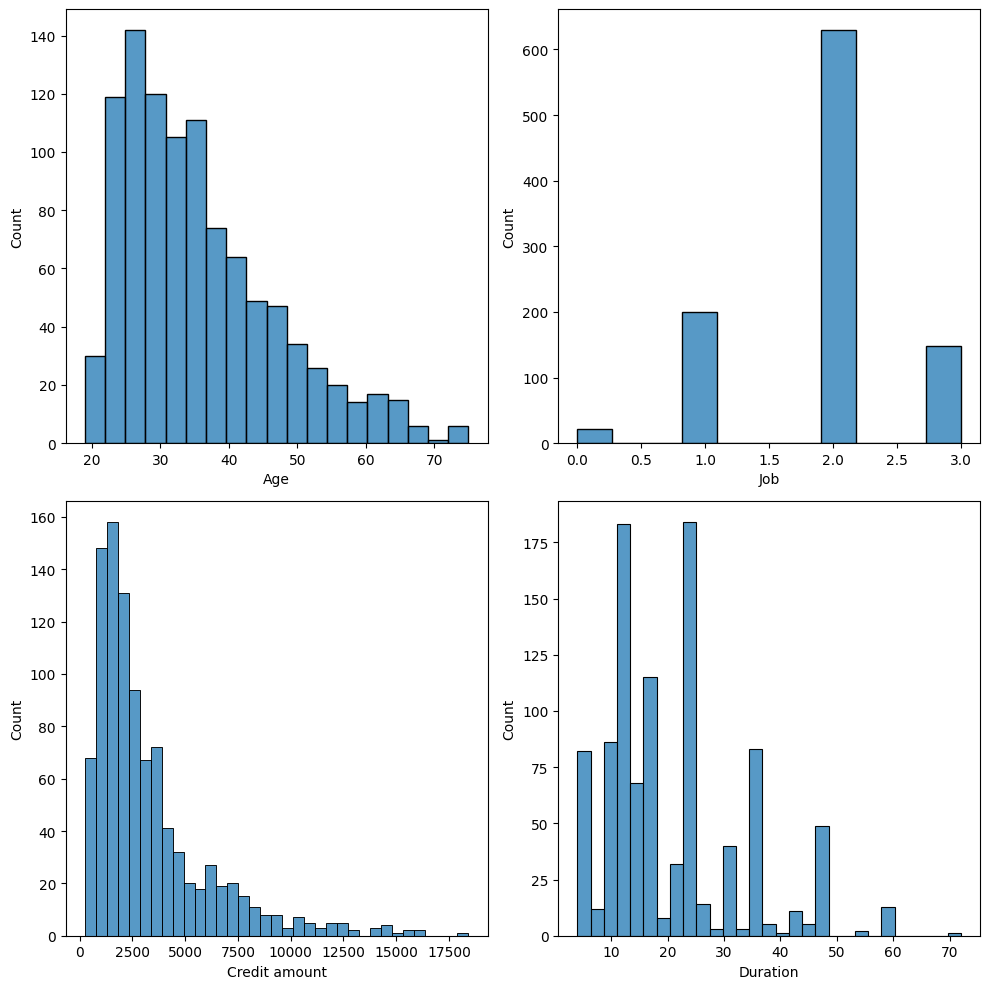

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt


fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.histplot(x='Age', data=credit, ax=axes[0, 0])
sns.histplot(x='Job', data=credit, ax=axes[0, 1])
sns.histplot(x='Credit amount', data=credit, ax=axes[1, 0])
sns.histplot(x='Duration', data=credit, ax=axes[1, 1])

plt.tight_layout()
plt.show()

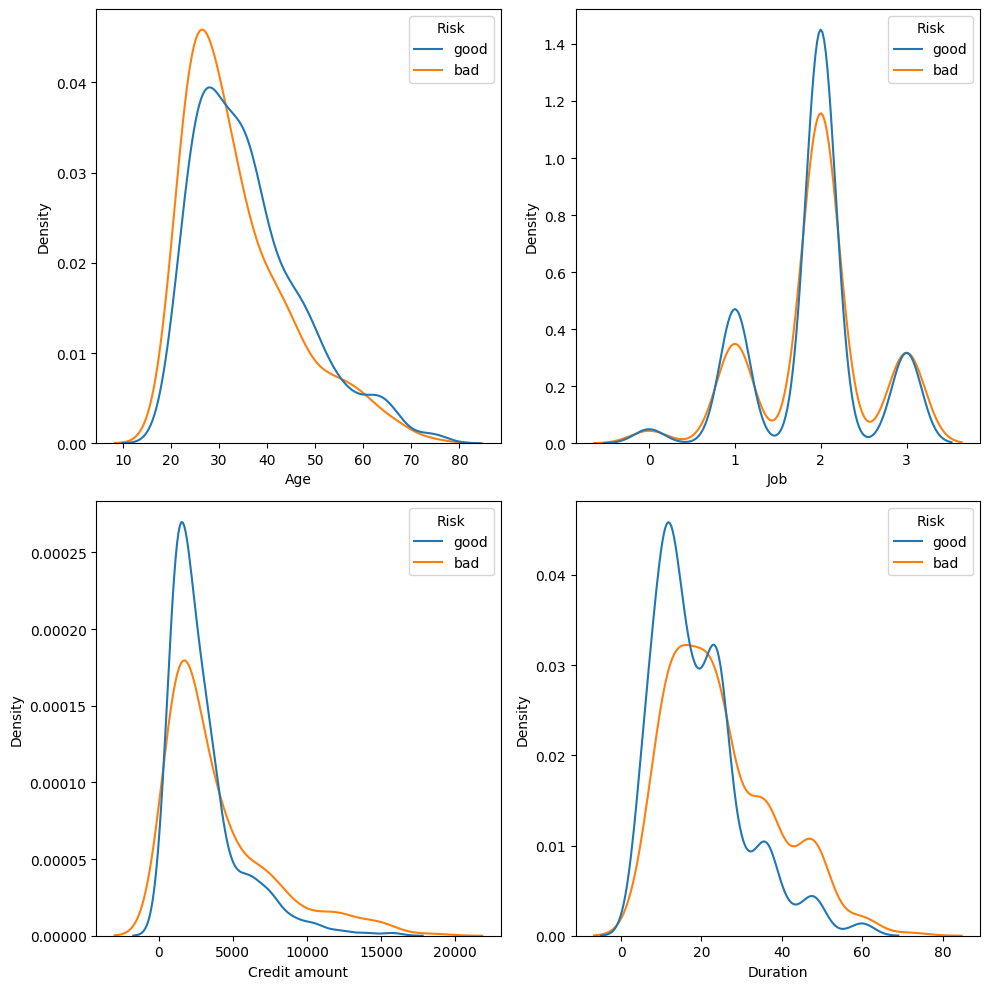

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.kdeplot(x='Age', hue='Risk', data=credit, ax=axes[0, 0], common_norm=False)
sns.kdeplot(x='Job', hue='Risk', data=credit, ax=axes[0, 1], common_norm=False)
sns.kdeplot(x='Credit amount', hue='Risk', data=credit, ax=axes[1, 0], common_norm=False)
sns.kdeplot(x='Duration', hue='Risk', data=credit, ax=axes[1, 1], common_norm=False)

plt.tight_layout()
plt.show()

In [40]:
cat_credit = credit.select_dtypes(include='O')
cat_credit.columns

Index(['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose',
       'Risk'],
      dtype='object')

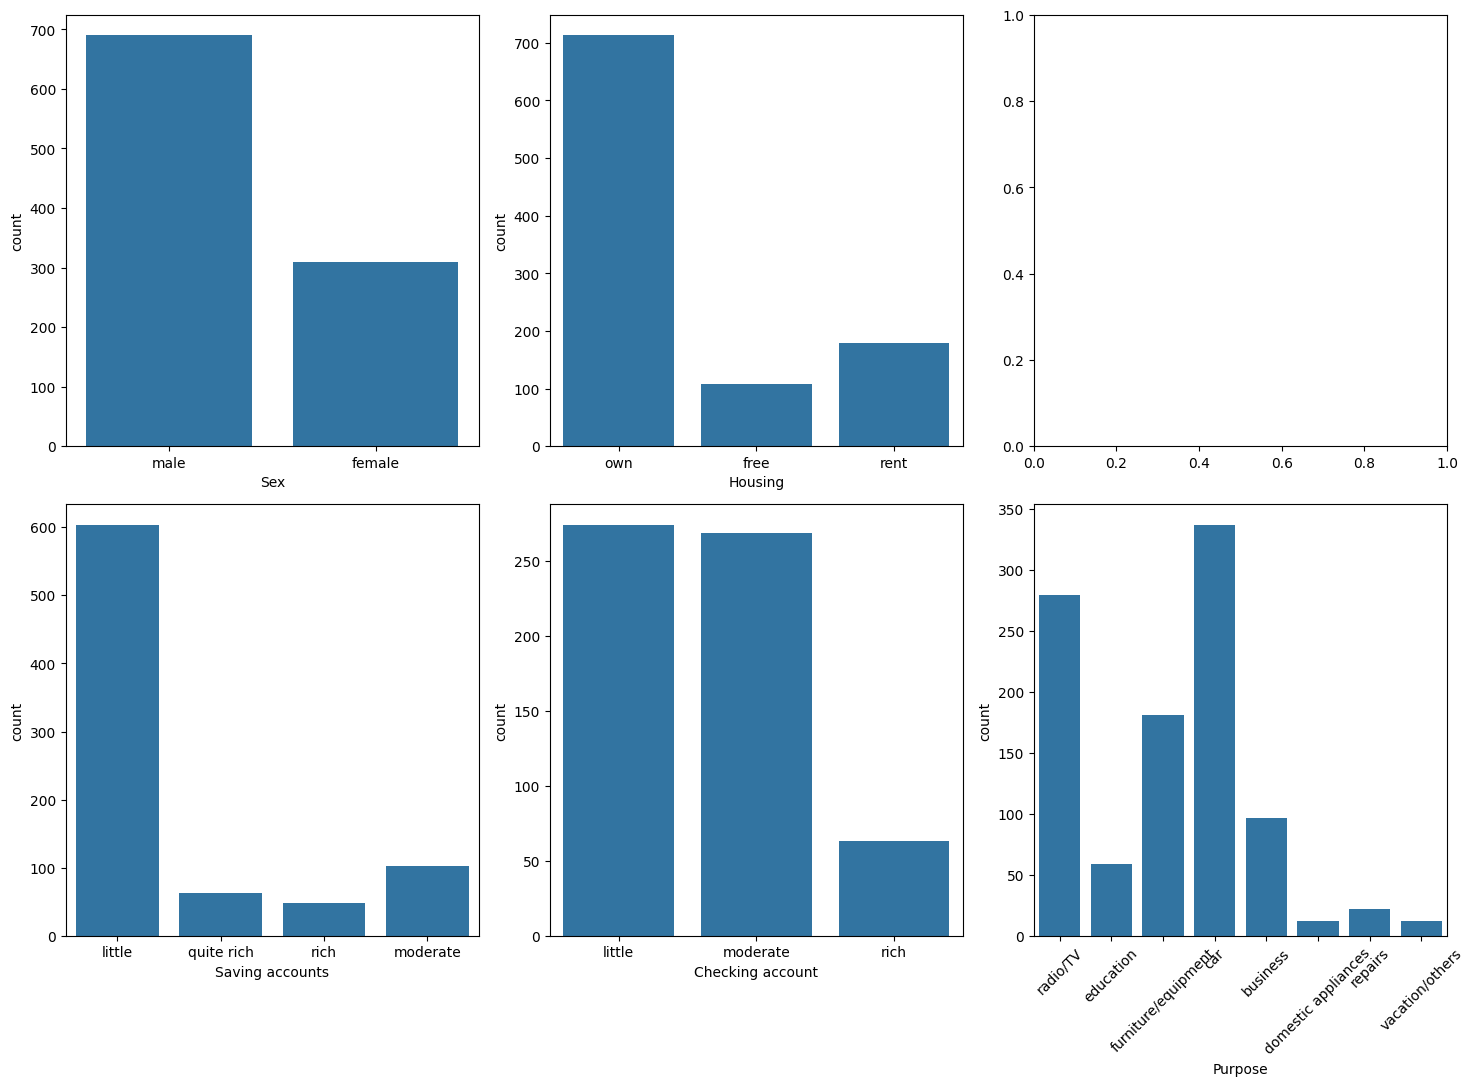

In [41]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='Sex', data=credit, ax=axes[0, 0])
sns.countplot(x='Housing', data=credit, ax=axes[0, 1])
sns.countplot(x='Saving accounts', data=credit, ax=axes[1, 0])
sns.countplot(x='Checking account', data=credit, ax=axes[1, 1])
sns.countplot(x='Purpose', data=credit, ax=axes[1, 2])

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

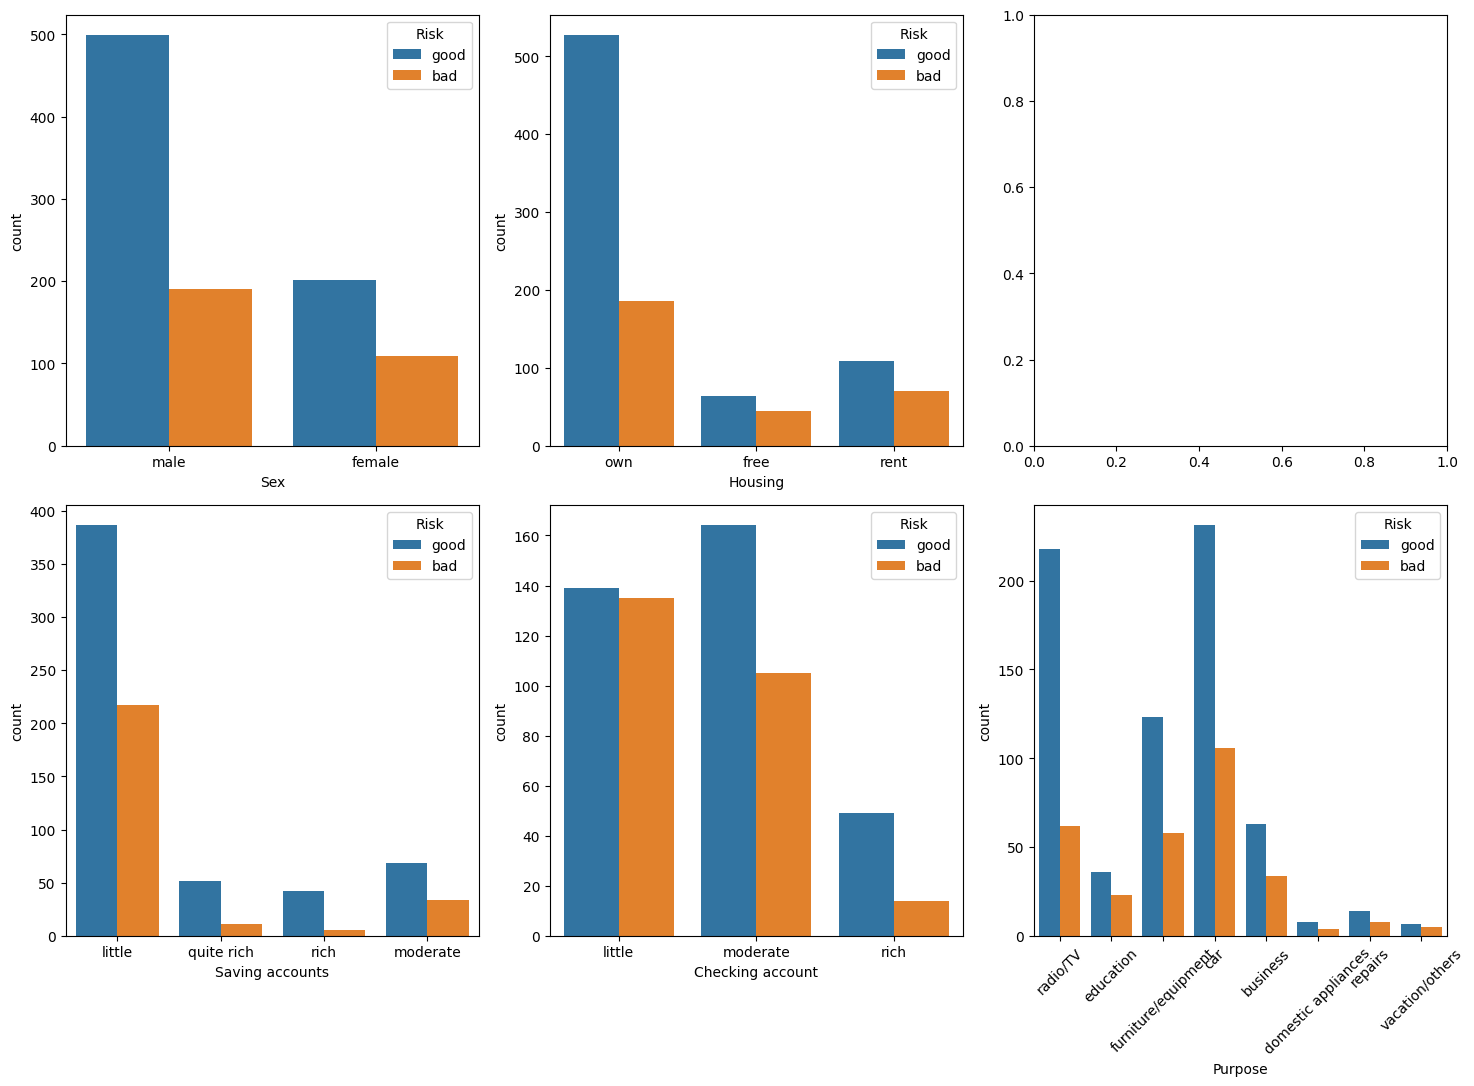

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.countplot(x='Sex', hue='Risk', data=credit, ax=axes[0, 0])
sns.countplot(x='Housing', hue='Risk', data=credit, ax=axes[0, 1])
sns.countplot(x='Saving accounts', hue='Risk', data=credit, ax=axes[1, 0])
sns.countplot(x='Checking account', hue='Risk', data=credit, ax=axes[1, 1])
sns.countplot(x='Purpose', hue='Risk', data=credit, ax=axes[1, 2])

plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

## Customer Segmentation

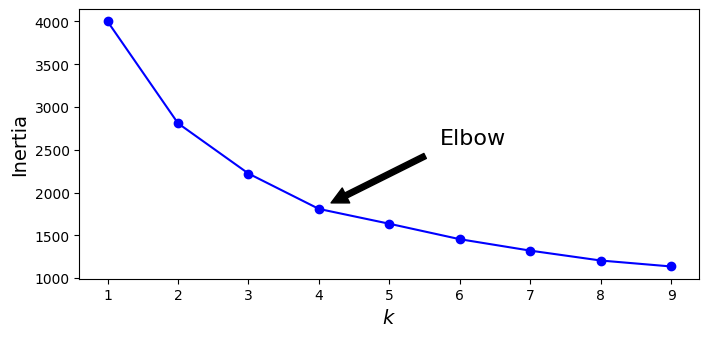

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

## try different k values
kmeans_per_k = [KMeans(n_clusters=k).fit(scaled_credit) for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
# plt.ylim(0, 1300)
plt.show()

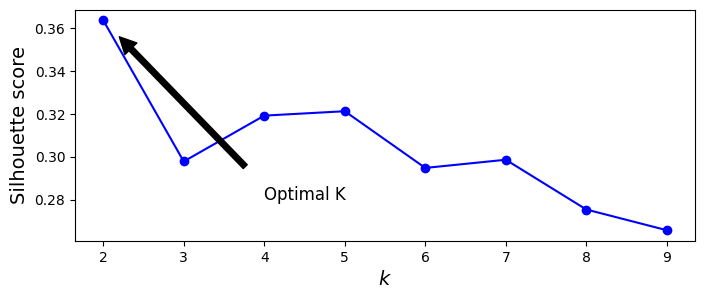

In [44]:
from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(scaled_credit, model.labels_) for model in kmeans_per_k[1:]]
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.annotate('Optimal K',
             xy=(2, silhouette_scores[0]),
             xytext=(0.33, 0.33),
             textcoords='figure fraction',
             fontsize=12,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.show()

### When `k=2`

In [45]:
kmeans = KMeans(n_clusters=2)
clusters = kmeans.fit_predict(scaled_credit)

In [46]:
numerical_credit.head(3)

,Age,Job,Credit amount,Duration
0,67,2,1169,6
1,22,2,5951,48
2,49,1,2096,12


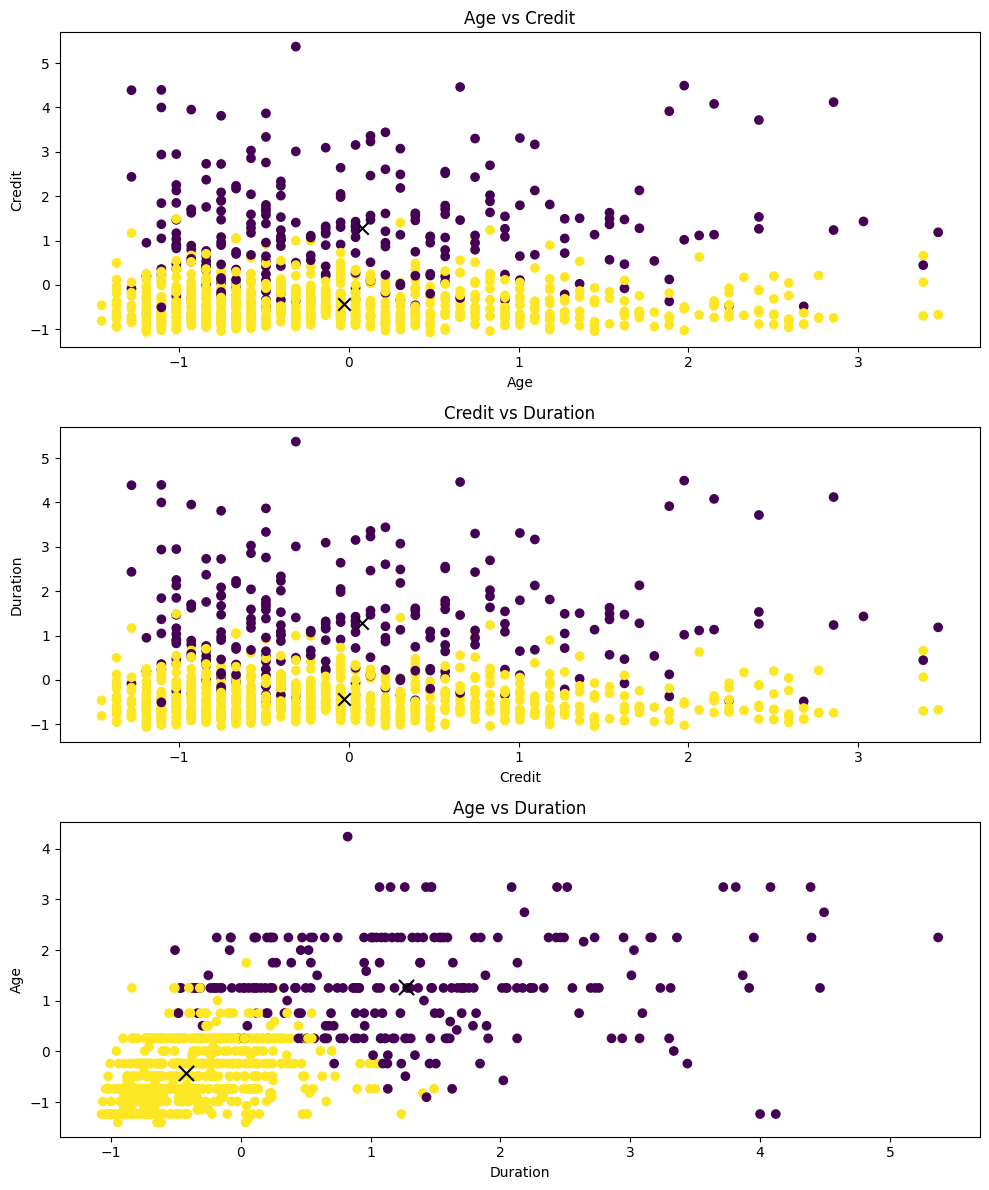

In [47]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s = 80, marker= 'x', color = 'k')
plt.xlabel('Age')
plt.ylabel('Credit')
plt.title('Age vs Credit')

plt.subplot(312)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s=80, marker='x', color='k')
plt.xlabel('Credit')
plt.ylabel('Duration')
plt.title('Credit vs Duration')

plt.subplot(313)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 3], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], s=120, marker='x', color='k')
plt.xlabel('Duration')
plt.ylabel('Age')
plt.title('Age vs Duration')

plt.tight_layout()
plt.show()

### When `k=4`

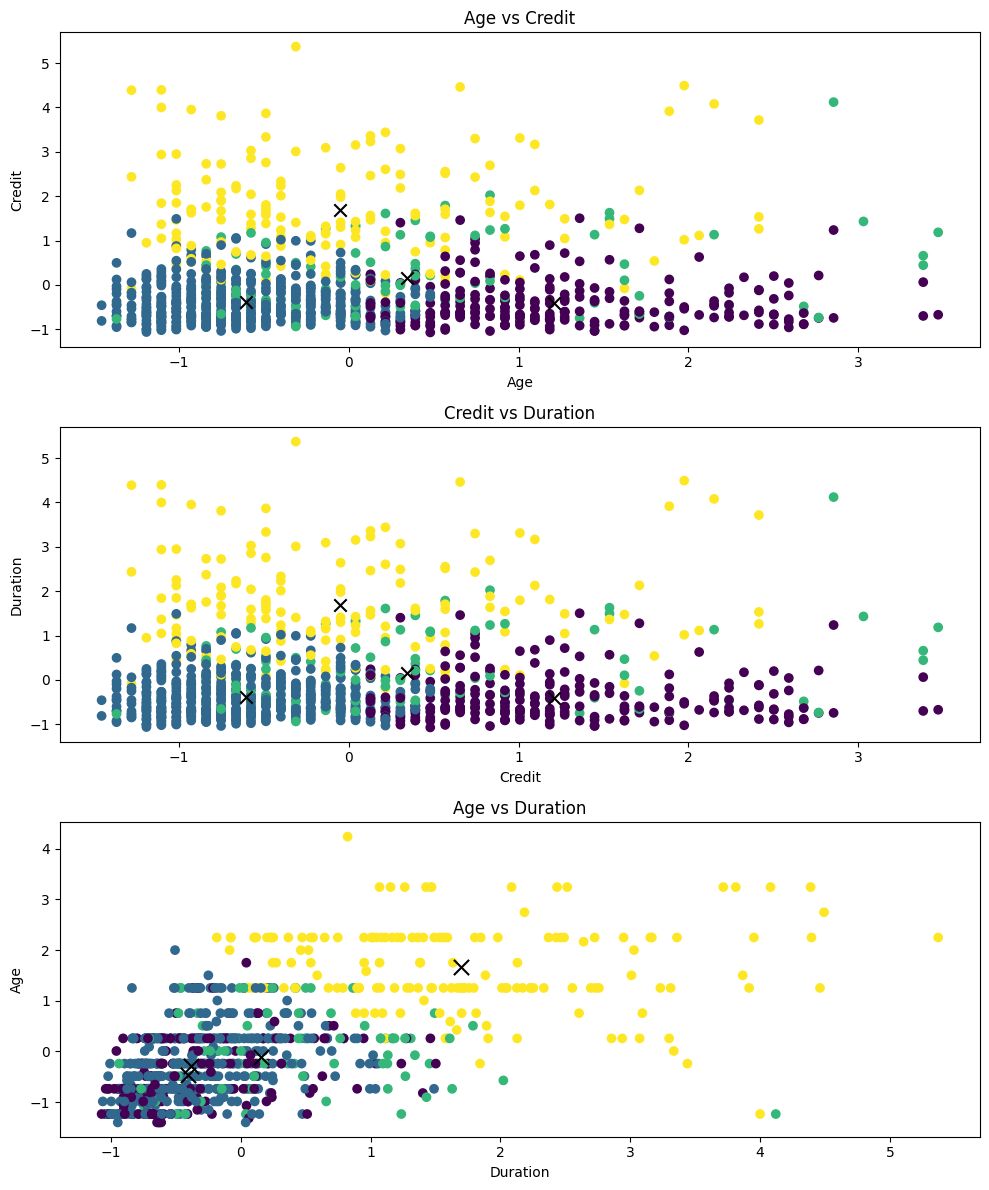

In [48]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(scaled_credit)

plt.figure(figsize=(10, 12))
plt.subplot(311)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s = 80, marker= 'x', color = 'k')
plt.xlabel('Age')
plt.ylabel('Credit')
plt.title('Age vs Credit')

plt.subplot(312)
plt.scatter(scaled_credit[:, 0], scaled_credit[:, 2], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 2], s=80, marker='x', color='k')
plt.xlabel('Credit')
plt.ylabel('Duration')
plt.title('Credit vs Duration')

plt.subplot(313)
plt.scatter(scaled_credit[:, 2], scaled_credit[:, 3], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3], s=120, marker='x', color='k')
plt.xlabel('Duration')
plt.ylabel('Age')
plt.title('Age vs Duration')

plt.tight_layout()
plt.show()

## Data Transformations

### Train-test Split

In [49]:
# convert all column names to lowercase and remove spaces
def clean_column_names(df):
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(r'\s+', '_', regex=True)
    return df

In [50]:
credit = clean_column_names(credit)
credit.head(3)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


In [51]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   age               1000 non-null   int64 
 1   sex               1000 non-null   object
 2   job               1000 non-null   int64 
 3   housing           1000 non-null   object
 4   saving_accounts   817 non-null    object
 5   checking_account  606 non-null    object
 6   credit_amount     1000 non-null   int64 
 7   duration          1000 non-null   int64 
 8   purpose           1000 non-null   object
 9   risk              1000 non-null   object
dtypes: int64(4), object(6)
memory usage: 78.3+ KB


In [52]:
credit['checking_account'].value_counts()

checking_account
little      274
moderate    269
rich         63
Name: count, dtype: int64

In [53]:
credit['saving_accounts'].value_counts()

saving_accounts
little        603
moderate      103
quite rich     63
rich           48
Name: count, dtype: int64

In [54]:
# Append the cluster labels to the original dataframe
kmeans = KMeans(n_clusters=2)
kmeans.fit(scaled_credit)

df = credit.copy()
df['cluster'] = kmeans.labels_
df.head(3)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk,cluster
0,67,male,2,own,NaN,little,1169,6,radio/TV,good,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad,0
2,49,male,1,own,little,NaN,2096,12,education,good,1


In [55]:
X = df.drop(columns=['risk'])
y = df['risk'].map(lambda x: 1 if x == 'bad' else 0)

In [56]:
y[:3], df['risk'][:3]

(0    0
 1    1
 2    0
 Name: risk, dtype: int64,
 0    good
 1     bad
 2    good
 Name: risk, dtype: object)

### Transformation Pipeline

In [57]:
X.head(3)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,cluster
0,67,male,2,own,NaN,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,NaN,2096,12,education,1


In [58]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

num_features = ['age', 'job', 'credit_amount', 'duration']
cat_features = ['sex', 'housing', 'saving_accounts', 'checking_account', 'purpose']

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing numeric values with mean
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  # Replace NaN with 'unknown'
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
], remainder='passthrough')  # Keep unlisted columns unchanged


### 1-Model fit

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

# Apply the transformation
X_transformed = preprocessor.fit_transform(X)
lr = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(lr, X_transformed, y, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(lr, X_transformed, y, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(lr, X_transformed, y, scoring='recall', cv=cv, n_jobs=-1)
precisions = cross_val_score(lr, X_transformed, y, scoring='precision', cv=cv, n_jobs=-1)
f1s = cross_val_score(lr, X_transformed, y, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean Precision: %.4f' % np.mean(precisions))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.7528
Mean Accuracy: 0.7407
Mean Recall: 0.3956
Mean Precision: 0.6008
Mean F1: 0.4708


### 2-Cluster Fit

In [60]:
X_transformed_0 = preprocessor.fit_transform(X[X.cluster == 0])
y_0 = y[X.cluster == 0]
lr = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(lr, X_transformed_0, y_0, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(lr, X_transformed_0, y_0, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(lr, X_transformed_0, y_0, scoring='recall', cv=cv, n_jobs=-1)
precisions = cross_val_score(lr, X_transformed_0, y_0, scoring='precision', cv=cv, n_jobs=-1)
f1s = cross_val_score(lr, X_transformed_0, y_0, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean Precision: %.4f' % np.mean(precisions))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.6633
Mean Accuracy: 0.6216
Mean Recall: 0.5848
Mean Precision: 0.5883
Mean F1: 0.5779


In [61]:
X_transformed_1 = preprocessor.fit_transform(X[X.cluster == 1])
y_1 = y[X.cluster == 1]
lr = LogisticRegression()

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(lr, X_transformed_1, y_1, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(lr, X_transformed_1, y_1, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(lr, X_transformed_1, y_1, scoring='recall', cv=cv, n_jobs=-1)
precisions = cross_val_score(lr, X_transformed_1, y_1, scoring='precision', cv=cv, n_jobs=-1)
f1s = cross_val_score(lr, X_transformed_1, y_1, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean Precision: %.4f' % np.mean(precisions))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.7553
Mean Accuracy: 0.7652
Mean Recall: 0.3070
Mean Precision: 0.5700
Mean F1: 0.3930


### `cluster_id` as a feature

In [62]:
from sklearn.ensemble import RandomForestClassifier

# Apply the transformation
X_transformed = preprocessor.fit_transform(X)
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(rf, X_transformed, y, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(rf, X_transformed, y, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(rf, X_transformed, y, scoring='recall', cv=cv, n_jobs=-1)
precisions = cross_val_score(rf, X_transformed, y, scoring='precision', cv=cv, n_jobs=-1)
f1s = cross_val_score(rf, X_transformed, y, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean Precision: %.4f' % np.mean(precisions))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.7578
Mean Accuracy: 0.7377
Mean Recall: 0.3733
Mean Precision: 0.6061
Mean F1: 0.4543


In [63]:
## Grid search

from sklearn.model_selection import GridSearchCV

# Define the parameter grid for Random Forest hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Define RandomForestClassifier model
rf = RandomForestClassifier(random_state=1)

# Define GridSearchCV with the parameter grid
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring='roc_auc')

# Apply the transformation and perform GridSearchCV
X_transformed = preprocessor.fit_transform(X)

# Fit GridSearchCV with cross-validation
grid_search.fit(X_transformed, y)

# Print the best parameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
243 fits failed out of a total of 729.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/xiangshiyin/Documents/Teaching/machine-learning-for-actuarial-science/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1382, in wrapper
    estima

Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [64]:
from sklearn.ensemble import RandomForestClassifier

# Apply the transformation
X_transformed = preprocessor.fit_transform(X)
# rf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=1, max_features='sqrt', min_samples_leaf=4, min_samples_split=2)
rf = grid_search.best_estimator_

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
roc_aucs = cross_val_score(rf, X_transformed, y, scoring='roc_auc', cv=cv, n_jobs=-1)
accuracies = cross_val_score(rf, X_transformed, y, scoring='accuracy', cv=cv, n_jobs=-1)
recalls = cross_val_score(rf, X_transformed, y, scoring='recall', cv=cv, n_jobs=-1)
precisions = cross_val_score(rf, X_transformed, y, scoring='precision', cv=cv, n_jobs=-1)
f1s = cross_val_score(rf, X_transformed, y, scoring='f1', cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.4f' % np.mean(roc_aucs))
print('Mean Accuracy: %.4f' % np.mean(accuracies))
print('Mean Recall: %.4f' % np.mean(recalls))
print('Mean Precision: %.4f' % np.mean(precisions))
print('Mean F1: %.4f' % np.mean(f1s))

Mean ROC AUC: 0.7716
Mean Accuracy: 0.7423
Mean Recall: 0.3300
Mean Precision: 0.6409
Mean F1: 0.4294


In [67]:
# Convert transformed array back to DataFrame (optional)
output_columns = (
    num_features + ['cluster'] + 
    list(preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(cat_features))
)

In [69]:
# Generate feature importance ranking
feature_importances = rf.feature_importances_

# Create a DataFrame with feature names and their corresponding importance values
importance_df = pd.DataFrame({
    'Feature': output_columns,
    'Importance': feature_importances
})

# Sort the features by their importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importance ranking
importance_df

,Feature,Importance
2,credit_amount,0.159538
3,duration,0.149979
17,checking_account_rich,0.132092
0,age,0.127187
14,saving_accounts_unknown,0.083424
15,checking_account_little,0.037227
1,job,0.035651
9,housing_rent,0.033415
26,purpose_vacation/others,0.032058
13,saving_accounts_rich,0.023592
